###  **Required Libraries**

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import zoom

###  **Root directory for OASIS dataset**

In [2]:
ROOT_PATH = "/kaggle/input/oasis-dataset-disk1"

###  **Step 1: Collect image paths and corresponding ages**

In [3]:
def collect_patient_data(root_path):
    all_patient_dirs = glob.glob(os.path.join(root_path, "disc*", "OAS1_*_MR1"))
    data = []
    for patient_dir in all_patient_dirs:
        txt_files = glob.glob(os.path.join(patient_dir, "*.txt"))
        img_files = glob.glob(os.path.join(patient_dir, "PROCESSED", "MPRAGE", "T88_111", "*_masked_gfc.img"))
        if txt_files and img_files:
            with open(txt_files[0], 'r') as f:
                for line in f:
                    if "age" in line.lower():
                        try:
                            age = float(line.strip().split(":")[-1])
                            data.append((img_files[0], age))
                        except:
                            continue
                        break
    return data

###  **Load Patient Data**

In [4]:
patient_data = collect_patient_data(ROOT_PATH)
print(f" Total valid patients found: {len(patient_data)}")

 Total valid patients found: 416


###  **Convert to DataFrame for Analysis**

In [5]:
df = pd.DataFrame(patient_data, columns=["image_path", "age"])
print("\n🔍 Dataset Summary Statistics:\n")
print(df.describe())


🔍 Dataset Summary Statistics:

              age
count  416.000000
mean    52.701923
std     25.082180
min     18.000000
25%     24.000000
50%     56.000000
75%     75.000000
max     96.000000


### **Patient Age Distribution**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


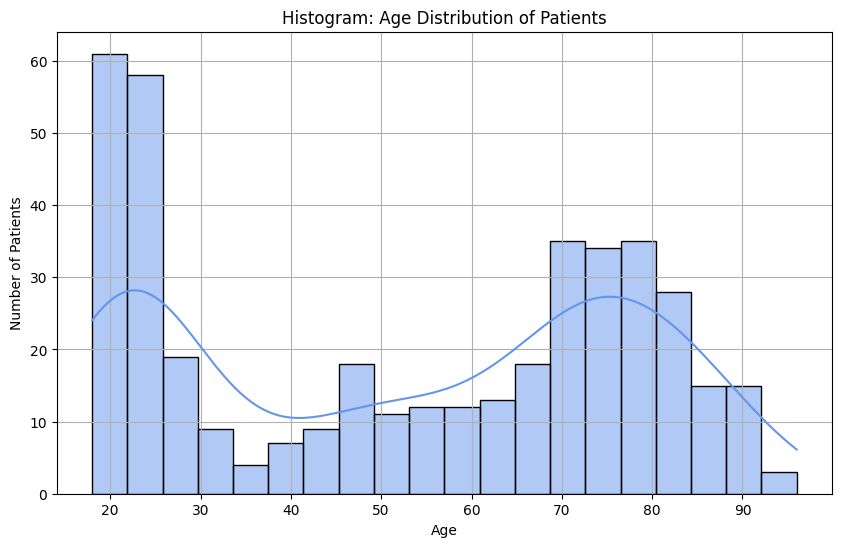

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=20, kde=True, color="cornflowerblue")
plt.title("Histogram: Age Distribution of Patients")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


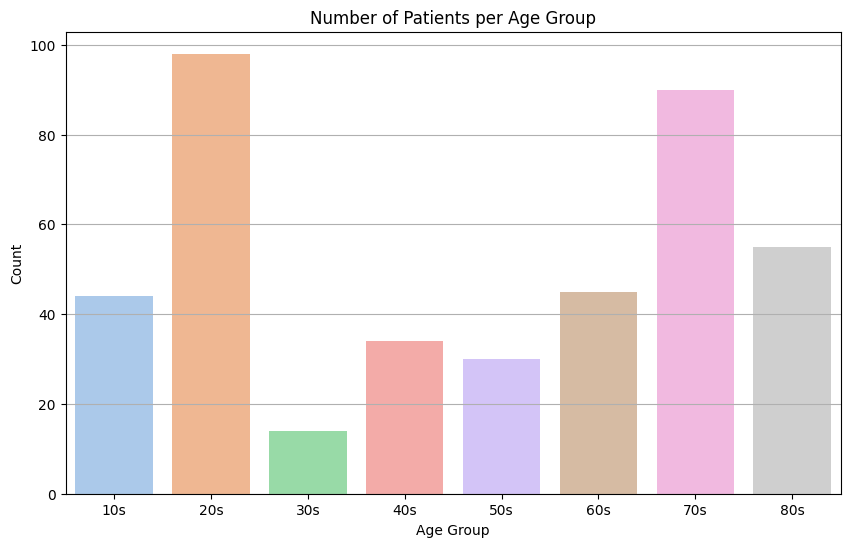

In [7]:
# Create age intervals like 20s, 30s, ...
df["age_group"] = pd.cut(df["age"],
                         bins=[10, 20, 30, 40, 50, 60, 70, 80, 90],
                         labels=["10s", "20s", "30s", "40s", "50s", "60s", "70s", "80s"])

plt.figure(figsize=(10, 6))
sns.countplot(x="age_group", data=df, palette="pastel")
plt.title("Number of Patients per Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.grid(axis="y")
plt.show()


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine


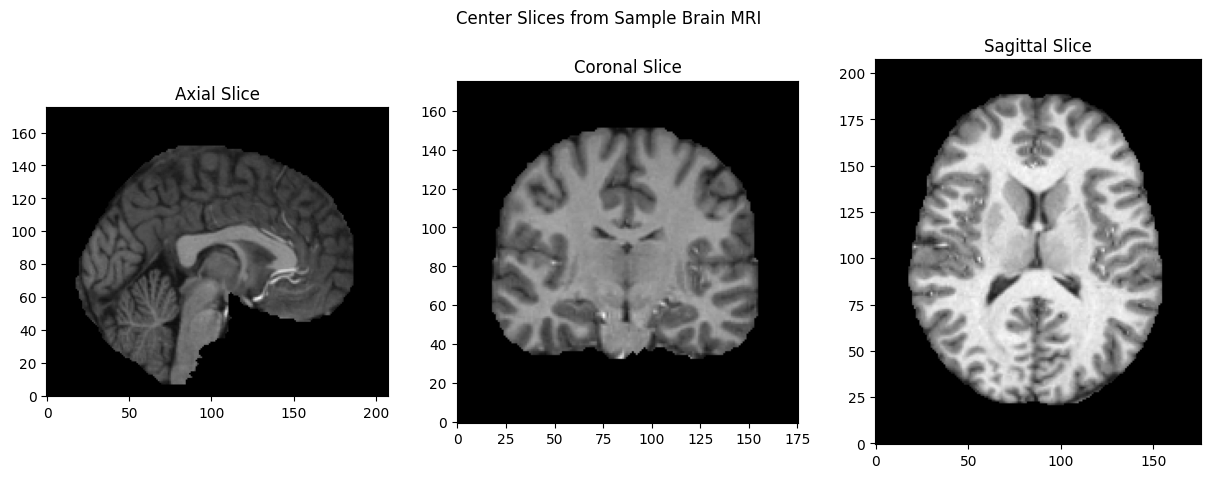

In [8]:
def show_center_slices(img_path):
    img = nib.load(img_path)
    vol = np.squeeze(img.get_fdata())
    vol = (vol - np.min(vol)) / (np.max(vol) - np.min(vol) + 1e-8)  # Normalize

    z, y, x = vol.shape[0] // 2, vol.shape[1] // 2, vol.shape[2] // 2
    axial = vol[z, :, :]
    coronal = vol[:, y, :]
    sagittal = vol[:, :, x]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(axial.T, cmap="gray", origin="lower")
    axes[0].set_title("Axial Slice")
    axes[1].imshow(coronal.T, cmap="gray", origin="lower")
    axes[1].set_title("Coronal Slice")
    axes[2].imshow(sagittal.T, cmap="gray", origin="lower")
    axes[2].set_title("Sagittal Slice")
    plt.suptitle("Center Slices from Sample Brain MRI")
    plt.show()

# 🧪 Try on 1st patient
if len(patient_data) > 0:
    show_center_slices(patient_data[0][0])


In [9]:
!pip install nibabel plotly

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Load Analyze-format image
file_path = "/kaggle/input/oasis-dataset-disk1/disc1/OAS1_0001_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0001_MR1_mpr_n4_anon_111_t88_gfc.img"
img = nib.load(file_path)

# Get image data and remove singleton dimensions
volume = np.squeeze(img.get_fdata())
print("Volume shape:", volume.shape)

# Normalize for better contrast
volume = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

# Unified function to display slices from different views
def display_slice(axis='axial', slice_index=0):
    plt.figure(figsize=(5,5))
    if axis == 'axial':
        plt.imshow(volume[:, :, slice_index].T, cmap='gray', origin='lower')
        plt.title(f'Axial Slice {slice_index}')
    elif axis == 'sagittal':
        plt.imshow(volume[slice_index, :, :].T, cmap='gray', origin='lower')
        plt.title(f'Sagittal Slice {slice_index}')
    elif axis == 'coronal':
        plt.imshow(volume[:, slice_index, :].T, cmap='gray', origin='lower')
        plt.title(f'Coronal Slice {slice_index}')
    plt.axis('off')
    plt.show()

# Widget to dynamically change axis and slice index
def view_all():
    axis_dropdown = widgets.Dropdown(options=['axial', 'sagittal', 'coronal'], value='axial', description='Axis:')
    
    def update(axis):
        if axis == 'axial':
            max_index = volume.shape[2] - 1
        elif axis == 'sagittal':
            max_index = volume.shape[0] - 1
        elif axis == 'coronal':
            max_index = volume.shape[1] - 1
        else:
            raise ValueError("Unknown axis")
        
        interact(display_slice, axis=widgets.fixed(axis), slice_index=(0, max_index))
    
    interact(update, axis=axis_dropdown)

# Show the interactive viewer
view_all()


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine


Volume shape: (176, 208, 176)


interactive(children=(Dropdown(description='Axis:', options=('axial', 'sagittal', 'coronal'), value='axial'), …

# Step 3: Model Implementation

In [2]:
!pip install nibabel timm

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import timm
from sklearn.model_selection import train_test_split
from glob import glob

# Configuration
base_dir = "/kaggle/input/oasis-dataset-disk1/disc1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 16


In [4]:
def extract_age(txt_path):
    with open(txt_path, 'r') as f:
        for line in f:
            if 'age:' in line.lower():
                return float(line.strip().split()[-1])
    return None

def load_and_extract_slices(hdr_path):
    img = nib.load(hdr_path)
    data = img.get_fdata()
    axial = data[:, :, data.shape[2] // 2]
    coronal = data[:, data.shape[1] // 2, :]
    sagittal = data[data.shape[0] // 2, :, :]
    return axial, coronal, sagittal

def preprocess_slice(slice_img, size=224):
    norm = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    resized = cv2.resize(norm, (size, size))
    rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_img)

class BrainAgeDataset(Dataset):
    def __init__(self, patient_paths, transform=None):
        self.patient_paths = patient_paths
        self.transform = transform

    def __len__(self):
        return len(self.patient_paths)

    def __getitem__(self, idx):
        patient_path = self.patient_paths[idx]
        hdr_file = glob(os.path.join(patient_path, "PROCESSED/MPRAGE/T88_111/*.hdr"))[0]
        axial, coronal, sagittal = load_and_extract_slices(hdr_file)
        axial_img = preprocess_slice(axial)
        coronal_img = preprocess_slice(coronal)
        sagittal_img = preprocess_slice(sagittal)
        if self.transform:
            axial_img = self.transform(axial_img)
            coronal_img = self.transform(coronal_img)
            sagittal_img = self.transform(sagittal_img)
        age_path = os.path.join(patient_path, os.path.basename(patient_path) + ".txt")
        age = extract_age(age_path)
        return axial_img, coronal_img, sagittal_img, torch.tensor(age, dtype=torch.float32)


In [5]:
class CNNAgePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.head = nn.Sequential(
            nn.Linear(64 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, axial, coronal, sagittal):
        x1 = self.feature_extractor(axial)
        x2 = self.feature_extractor(coronal)
        x3 = self.feature_extractor(sagittal)
        x = torch.cat([x1, x2, x3], dim=1)
        return self.head(x).squeeze()

class ResNetAgePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        resnet.fc = nn.Identity()
        self.feature_extractor = resnet
        self.head = nn.Sequential(
            nn.Linear(2048 * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, axial, coronal, sagittal):
        x1 = self.feature_extractor(axial)
        x2 = self.feature_extractor(coronal)
        x3 = self.feature_extractor(sagittal)
        x = torch.cat([x1, x2, x3], dim=1)
        return self.head(x).squeeze()

class SwinAgePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.backbone.num_features * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, axial, coronal, sagittal):
        x1 = self.backbone(axial)
        x2 = self.backbone(coronal)
        x3 = self.backbone(sagittal)
        x = torch.cat([x1, x2, x3], dim=1)
        return self.head(x).squeeze()


In [6]:
def train_model(model, label, color, train_loader, val_loader, epochs=20):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.L1Loss()
    train_mae_list, val_mae_list = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for axial, coronal, sagittal, age in train_loader:
            axial, coronal, sagittal, age = axial.to(device), coronal.to(device), sagittal.to(device), age.to(device)
            optimizer.zero_grad()
            loss = criterion(model(axial, coronal, sagittal), age)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * axial.size(0)
        train_mae = train_loss / len(train_loader.dataset)
        train_mae_list.append(train_mae)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for axial, coronal, sagittal, age in val_loader:
                axial, coronal, sagittal, age = axial.to(device), coronal.to(device), sagittal.to(device), age.to(device)
                loss = criterion(model(axial, coronal, sagittal), age)
                val_loss += loss.item() * axial.size(0)
        val_mae = val_loss / len(val_loader.dataset)
        val_mae_list.append(val_mae)

        print(f"[{label}] Epoch {epoch+1}/{epochs} - Train MAE: {train_mae:.2f}, Val MAE: {val_mae:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(train_mae_list, label=f'{label} Train MAE', color=color)
    plt.plot(val_mae_list, label=f'{label} Val MAE', color=color, linestyle='--')
    plt.title(f"{label} MAE")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return train_mae_list, val_mae_list


In [7]:
# Prepare data
all_patient_paths = sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d)) and os.path.exists(os.path.join(base_dir, d, "PROCESSED/MPRAGE/T88_111"))])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_paths, val_paths = train_test_split(all_patient_paths, test_size=0.2, random_state=42)
train_loader = DataLoader(BrainAgeDataset(train_paths, transform), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(BrainAgeDataset(val_paths, transform), batch_size=BATCH_SIZE)



very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 1/20 - Train MAE: 51.66, Val MAE: 49.99


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 2/20 - Train MAE: 51.37, Val MAE: 49.59


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 3/20 - Train MAE: 50.80, Val MAE: 48.78


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 4/20 - Train MAE: 49.55, Val MAE: 46.89


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 5/20 - Train MAE: 46.74, Val MAE: 42.78


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 6/20 - Train MAE: 40.93, Val MAE: 34.76


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 7/20 - Train MAE: 31.16, Val MAE: 25.98


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 8/20 - Train MAE: 25.70, Val MAE: 23.41


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 9/20 - Train MAE: 23.28, Val MAE: 22.28


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 10/20 - Train MAE: 22.18, Val MAE: 22.27


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 11/20 - Train MAE: 22.11, Val MAE: 22.32


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 12/20 - Train MAE: 22.15, Val MAE: 22.38


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 13/20 - Train MAE: 22.15, Val MAE: 22.22


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 14/20 - Train MAE: 22.09, Val MAE: 22.30


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 15/20 - Train MAE: 22.09, Val MAE: 22.23


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 16/20 - Train MAE: 22.07, Val MAE: 22.30


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 17/20 - Train MAE: 22.06, Val MAE: 22.27


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 18/20 - Train MAE: 22.03, Val MAE: 22.25


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 19/20 - Train MAE: 22.00, Val MAE: 22.13


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Custom CNN] Epoch 20/20 - Train MAE: 22.06, Val MAE: 22.20


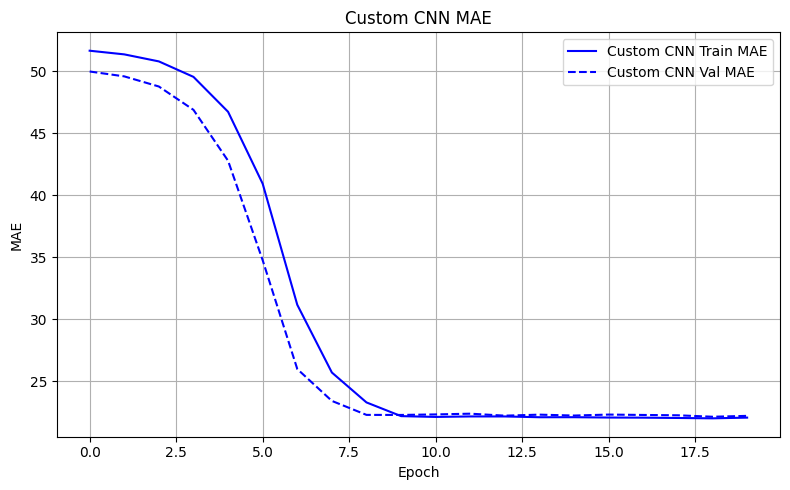

In [47]:
# Run each model
cnn_model = CNNAgePredictor()
cnn_train, cnn_val = train_model(cnn_model, "Custom CNN", "blue", train_loader, val_loader)

very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 1/20 - Train MAE: 42.74, Val MAE: 29.17


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 2/20 - Train MAE: 22.21, Val MAE: 14.31


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 3/20 - Train MAE: 11.61, Val MAE: 8.19


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 4/20 - Train MAE: 8.49, Val MAE: 11.13


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 5/20 - Train MAE: 8.10, Val MAE: 6.72


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 6/20 - Train MAE: 6.49, Val MAE: 6.86


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 7/20 - Train MAE: 6.52, Val MAE: 6.59


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 8/20 - Train MAE: 7.35, Val MAE: 8.15


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 9/20 - Train MAE: 6.09, Val MAE: 7.24


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 10/20 - Train MAE: 5.91, Val MAE: 7.54


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 11/20 - Train MAE: 5.45, Val MAE: 7.78


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 12/20 - Train MAE: 4.57, Val MAE: 6.52


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 13/20 - Train MAE: 4.10, Val MAE: 7.10


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 14/20 - Train MAE: 4.22, Val MAE: 6.59


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 15/20 - Train MAE: 5.21, Val MAE: 7.68


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 16/20 - Train MAE: 4.46, Val MAE: 6.94


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 17/20 - Train MAE: 4.65, Val MAE: 6.80


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 18/20 - Train MAE: 4.44, Val MAE: 5.83


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 19/20 - Train MAE: 4.14, Val MAE: 6.01


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ResNet-50] Epoch 20/20 - Train MAE: 3.75, Val MAE: 6.77


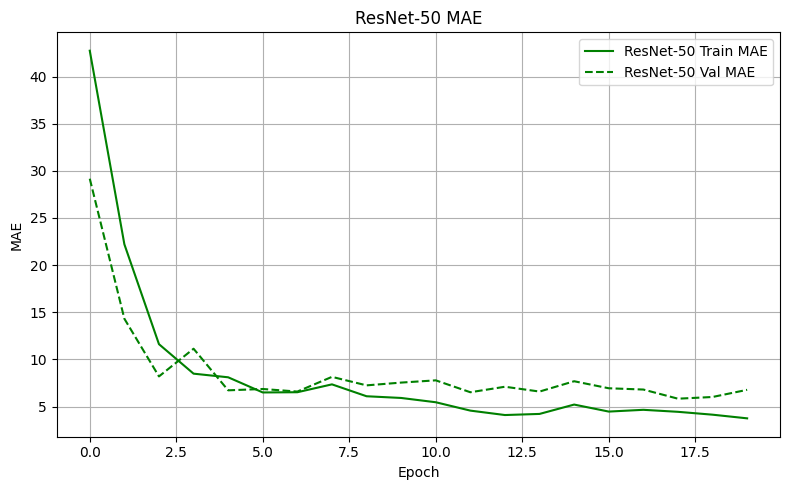

In [8]:
resnet_model = ResNetAgePredictor()
resnet_train, resnet_val = train_model(resnet_model, "ResNet-50", "green", train_loader, val_loader)

very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 1/20 - Train MAE: 35.09, Val MAE: 23.54


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 2/20 - Train MAE: 21.88, Val MAE: 17.46


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 3/20 - Train MAE: 11.44, Val MAE: 7.38


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 4/20 - Train MAE: 7.02, Val MAE: 6.67


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 5/20 - Train MAE: 6.27, Val MAE: 7.53


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 6/20 - Train MAE: 5.88, Val MAE: 5.96


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 7/20 - Train MAE: 5.30, Val MAE: 5.62


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 8/20 - Train MAE: 4.88, Val MAE: 6.55


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 9/20 - Train MAE: 3.98, Val MAE: 5.51


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 10/20 - Train MAE: 3.64, Val MAE: 5.95


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 11/20 - Train MAE: 4.17, Val MAE: 7.99


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 12/20 - Train MAE: 4.70, Val MAE: 8.54


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 13/20 - Train MAE: 3.72, Val MAE: 6.79


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 14/20 - Train MAE: 4.42, Val MAE: 5.50


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 15/20 - Train MAE: 3.15, Val MAE: 5.59


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 16/20 - Train MAE: 2.76, Val MAE: 5.60


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 17/20 - Train MAE: 2.50, Val MAE: 5.68


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 18/20 - Train MAE: 2.42, Val MAE: 5.24


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 19/20 - Train MAE: 2.00, Val MAE: 4.85


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[Swin Transformer] Epoch 20/20 - Train MAE: 1.99, Val MAE: 5.02


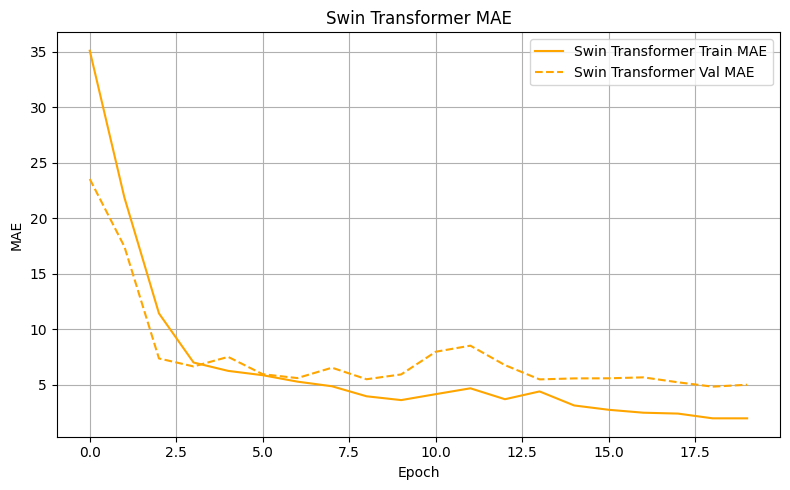

In [9]:
swin_model = SwinAgePredictor()
swin_train, swin_val = train_model(swin_model, "Swin Transformer", "orange", train_loader, val_loader)

# **Prediction**

In [15]:
def predict_and_compare_age(patient_path, model, transform, device):
    model.eval()
    model.to(device)

    # Get age (actual)
    txt_file = os.path.join(patient_path, os.path.basename(patient_path) + ".txt")
    actual_age = extract_age(txt_file)

    # Get slices
    hdr_file = glob(os.path.join(patient_path, "PROCESSED/MPRAGE/T88_111/*.hdr"))[0]
    axial, coronal, sagittal = load_and_extract_slices(hdr_file)

    # Preprocess
    axial_img = transform(preprocess_slice(axial)).unsqueeze(0).to(device)
    coronal_img = transform(preprocess_slice(coronal)).unsqueeze(0).to(device)
    sagittal_img = transform(preprocess_slice(sagittal)).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        predicted_age = model(axial_img, coronal_img, sagittal_img).item()

    # Display
    print(f"Actual Age: {actual_age:.2f} years")
    print(f"Predicted Age (Swin): {predicted_age:.2f} years")


In [16]:
# Pick any patient from validation set
example_path = val_paths[0]  # or use a specific path
predict_and_compare_age(example_path, swin_model, transform, device)


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine


Actual Age: 21.00 years
Predicted Age (Swin): 21.56 years


# **Custom Transformer**

very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 1/20 - Train MAE: 30.86, Val MAE: 22.61


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 2/20 - Train MAE: 18.03, Val MAE: 9.36


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 3/20 - Train MAE: 10.60, Val MAE: 8.72


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 4/20 - Train MAE: 7.60, Val MAE: 9.09


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 5/20 - Train MAE: 6.66, Val MAE: 7.73


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 6/20 - Train MAE: 7.52, Val MAE: 8.38


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 7/20 - Train MAE: 6.24, Val MAE: 6.17


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 8/20 - Train MAE: 5.29, Val MAE: 6.67


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 9/20 - Train MAE: 5.49, Val MAE: 6.99


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 10/20 - Train MAE: 5.80, Val MAE: 7.45


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 11/20 - Train MAE: 4.62, Val MAE: 7.64


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 12/20 - Train MAE: 4.58, Val MAE: 8.35


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 13/20 - Train MAE: 4.76, Val MAE: 5.69


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 14/20 - Train MAE: 3.46, Val MAE: 8.11


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 15/20 - Train MAE: 4.12, Val MAE: 6.46


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 16/20 - Train MAE: 3.75, Val MAE: 6.63


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 17/20 - Train MAE: 2.94, Val MAE: 5.43


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 18/20 - Train MAE: 2.82, Val MAE: 6.13


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 19/20 - Train MAE: 2.75, Val MAE: 6.23


very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving a

[ViT] Epoch 20/20 - Train MAE: 2.43, Val MAE: 5.46


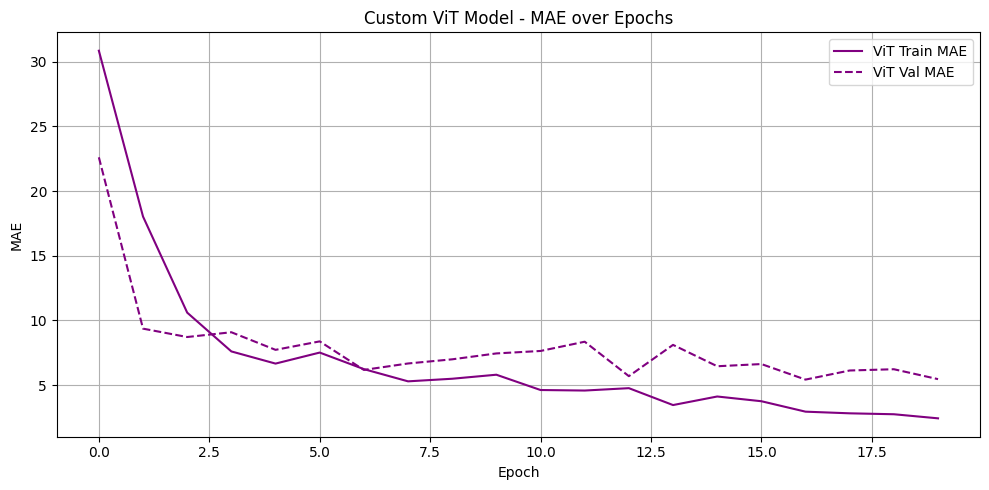

In [2]:
import os, torch, nibabel as nib, numpy as np, cv2
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import timm

# ==== CONFIG ====
base_dir = "/kaggle/input/oasis-dataset-disk1/disc1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 20
BATCH_SIZE = 16

# ==== HELPERS ====
def extract_age(txt_path):
    with open(txt_path, 'r') as f:
        for line in f:
            if 'age:' in line.lower():
                return float(line.strip().split()[-1])
    return None

def load_and_extract_slices(hdr_path):
    img = nib.load(hdr_path)
    data = img.get_fdata()
    axial = data[:, :, data.shape[2] // 2]
    coronal = data[:, data.shape[1] // 2, :]
    sagittal = data[data.shape[0] // 2, :, :]
    return axial, coronal, sagittal

def preprocess_slice(slice_img, size=224):
    norm = cv2.normalize(slice_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    resized = cv2.resize(norm, (size, size))
    rgb_img = cv2.cvtColor(resized, cv2.COLOR_GRAY2RGB)
    return Image.fromarray(rgb_img)

class BrainAgeDataset(Dataset):
    def __init__(self, patient_paths, transform=None):
        self.patient_paths = patient_paths
        self.transform = transform

    def __len__(self):
        return len(self.patient_paths)

    def __getitem__(self, idx):
        path = self.patient_paths[idx]
        hdr = glob(os.path.join(path, "PROCESSED/MPRAGE/T88_111/*.hdr"))[0]
        axial, coronal, sagittal = load_and_extract_slices(hdr)
        axial_img = preprocess_slice(axial)
        coronal_img = preprocess_slice(coronal)
        sagittal_img = preprocess_slice(sagittal)
        if self.transform:
            axial_img = self.transform(axial_img)
            coronal_img = self.transform(coronal_img)
            sagittal_img = self.transform(sagittal_img)
        age_path = os.path.join(path, os.path.basename(path) + ".txt")
        age = extract_age(age_path)
        return axial_img, coronal_img, sagittal_img, torch.tensor(age, dtype=torch.float32)

# ==== ViT Model ====
class ViTAgePredictor(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(self.vit.num_features * 3, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, axial, coronal, sagittal):
        x1 = self.vit(axial)
        x2 = self.vit(coronal)
        x3 = self.vit(sagittal)
        x = torch.cat([x1, x2, x3], dim=1)
        return self.head(x).squeeze()

# ==== Prepare Data ====
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

all_paths = sorted([os.path.join(base_dir, d) for d in os.listdir(base_dir)
                    if os.path.isdir(os.path.join(base_dir, d)) and 
                    os.path.exists(os.path.join(base_dir, d, "PROCESSED/MPRAGE/T88_111"))])

train_paths, val_paths = train_test_split(all_paths, test_size=0.2, random_state=42)
train_ds = BrainAgeDataset(train_paths, transform)
val_ds = BrainAgeDataset(val_paths, transform)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# ==== Train ====
model = ViTAgePredictor().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
train_mae, val_mae = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for axial, coronal, sagittal, age in train_dl:
        axial, coronal, sagittal, age = axial.to(device), coronal.to(device), sagittal.to(device), age.to(device)
        opt.zero_grad()
        loss = criterion(model(axial, coronal, sagittal), age)
        loss.backward()
        opt.step()
        train_loss += loss.item() * axial.size(0)
    train_mae.append(train_loss / len(train_dl.dataset))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for axial, coronal, sagittal, age in val_dl:
            axial, coronal, sagittal, age = axial.to(device), coronal.to(device), sagittal.to(device), age.to(device)
            val_loss += criterion(model(axial, coronal, sagittal), age).item() * axial.size(0)
    val_mae.append(val_loss / len(val_dl.dataset))
    print(f"[ViT] Epoch {epoch+1}/{EPOCHS} - Train MAE: {train_mae[-1]:.2f}, Val MAE: {val_mae[-1]:.2f}")

# ==== Plot MAE ====
plt.figure(figsize=(10, 5))
plt.plot(train_mae, label="ViT Train MAE", color="purple")
plt.plot(val_mae, label="ViT Val MAE", linestyle="--", color="purple")
plt.title("Custom ViT Model - MAE over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
